In [1]:
from pystac_client import Client
from odc.stac import load, configure_s3_access
from odc.geo import Geometry
from dask.distributed import Client as DaskClient

import geopandas as gpd

from utils import WGS84GRID30, USGSCATALOG, USGSLANDSAT, http_to_s3_url, mask_usgs_landsat, create_land_productivity_indices

In [2]:
# Configure S3 access, which requires AWS credentials for loading USGS Landsat data
configure_s3_access(cloud_defaults=True, requester_pays=True)

client = Client.open(USGSCATALOG)

In [3]:
# Load our extents
gdf = gpd.read_file("aois.geojson")

# 0 is Fiji, 1 is Caribbean and 2 is Belize
geom = Geometry(gdf.geometry[0], crs="epsg:4326")

# This is all the tiles
tiles = WGS84GRID30.tiles_from_geopolygon(geom)

# This is near Suva, Fiji
tile = WGS84GRID30.tile_geobox((119, -13))

# Subset the tile, to load a very small area
tile = tile.crop([250, 250])

In [4]:
type(tile)

odc.geo.geobox.GeoBox

In [5]:
items = client.search(
    collections=[USGSLANDSAT],
    intersects=tile.geographic_extent,
    datetime="2022-11/2024-01",
    query={"landsat:collection_category": {"in": ["T1"]}},
).item_collection()

print(f"Found {len(items)} items")

Found 97 items


In [6]:
data = load(
    items,
    geobox=tile,
    measurements=["red", "nir08", "qa_pixel"],
    chunks={"x": 2048, "y": 2048},
    groupby="solar_day",
    dtype="uint16",
    nodata=0,
    resampling={"qa_pixel": "nearest"},
    patch_url=http_to_s3_url,
)

data = data.rename_vars({"nir08": "nir"})

data

<xarray.Dataset> Size: 20MB
Dimensions:      (latitude: 250, longitude: 250, time: 53)
Coordinates:
  * latitude     (latitude) float64 2kB -18.0 -18.0 -18.0 ... -18.07 -18.07
  * longitude    (longitude) float64 2kB 178.5 178.5 178.5 ... 178.6 178.6 178.6
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 424B 2022-11-05T22:07:15.885529 ... 20...
Data variables:
    red          (time, latitude, longitude) uint16 7MB dask.array<chunksize=(1, 250, 250), meta=np.ndarray>
    nir          (time, latitude, longitude) uint16 7MB dask.array<chunksize=(1, 250, 250), meta=np.ndarray>
    qa_pixel     (time, latitude, longitude) uint16 7MB dask.array<chunksize=(1, 250, 250), meta=np.ndarray>

In [7]:
# Create cloud mask, scale values to 0-1 and set nodata to NaN
masked = mask_usgs_landsat(data)

In [8]:
# Create the NDVI, MSAVI and EVI2
indices = create_land_productivity_indices(masked, drop=False)

indices

<xarray.Dataset> Size: 133MB
Dimensions:      (time: 53, latitude: 250, longitude: 250)
Coordinates:
  * latitude     (latitude) float64 2kB -18.0 -18.0 -18.0 ... -18.07 -18.07
  * longitude    (longitude) float64 2kB 178.5 178.5 178.5 ... 178.6 178.6 178.6
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 424B 2022-11-05T22:07:15.885529 ... 20...
Data variables:
    red          (time, latitude, longitude) float64 26MB dask.array<chunksize=(1, 250, 250), meta=np.ndarray>
    nir          (time, latitude, longitude) float64 26MB dask.array<chunksize=(1, 250, 250), meta=np.ndarray>
    ndvi         (time, latitude, longitude) float64 26MB dask.array<chunksize=(1, 250, 250), meta=np.ndarray>
    msavi        (time, latitude, longitude) float64 26MB dask.array<chunksize=(1, 250, 250), meta=np.ndarray>
    evi2         (time, latitude, longitude) float64 26MB dask.array<chunksize=(1, 250, 250), meta=np.ndarray>

In [9]:
with DaskClient(n_workers=1, threads_per_worker=16) as client:
    loaded = indices.compute()

loaded

/opt/homebrew/lib/python3.11/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/opt/homebrew/lib/python3.11/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


<xarray.Dataset> Size: 133MB
Dimensions:      (time: 53, latitude: 250, longitude: 250)
Coordinates:
  * latitude     (latitude) float64 2kB -18.0 -18.0 -18.0 ... -18.07 -18.07
  * longitude    (longitude) float64 2kB 178.5 178.5 178.5 ... 178.6 178.6 178.6
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 424B 2022-11-05T22:07:15.885529 ... 20...
Data variables:
    red          (time, latitude, longitude) float64 26MB nan nan ... nan nan
    nir          (time, latitude, longitude) float64 26MB nan nan ... nan nan
    ndvi         (time, latitude, longitude) float64 26MB nan nan ... nan nan
    msavi        (time, latitude, longitude) float64 26MB nan nan ... nan nan
    evi2         (time, latitude, longitude) float64 26MB nan nan ... nan nan

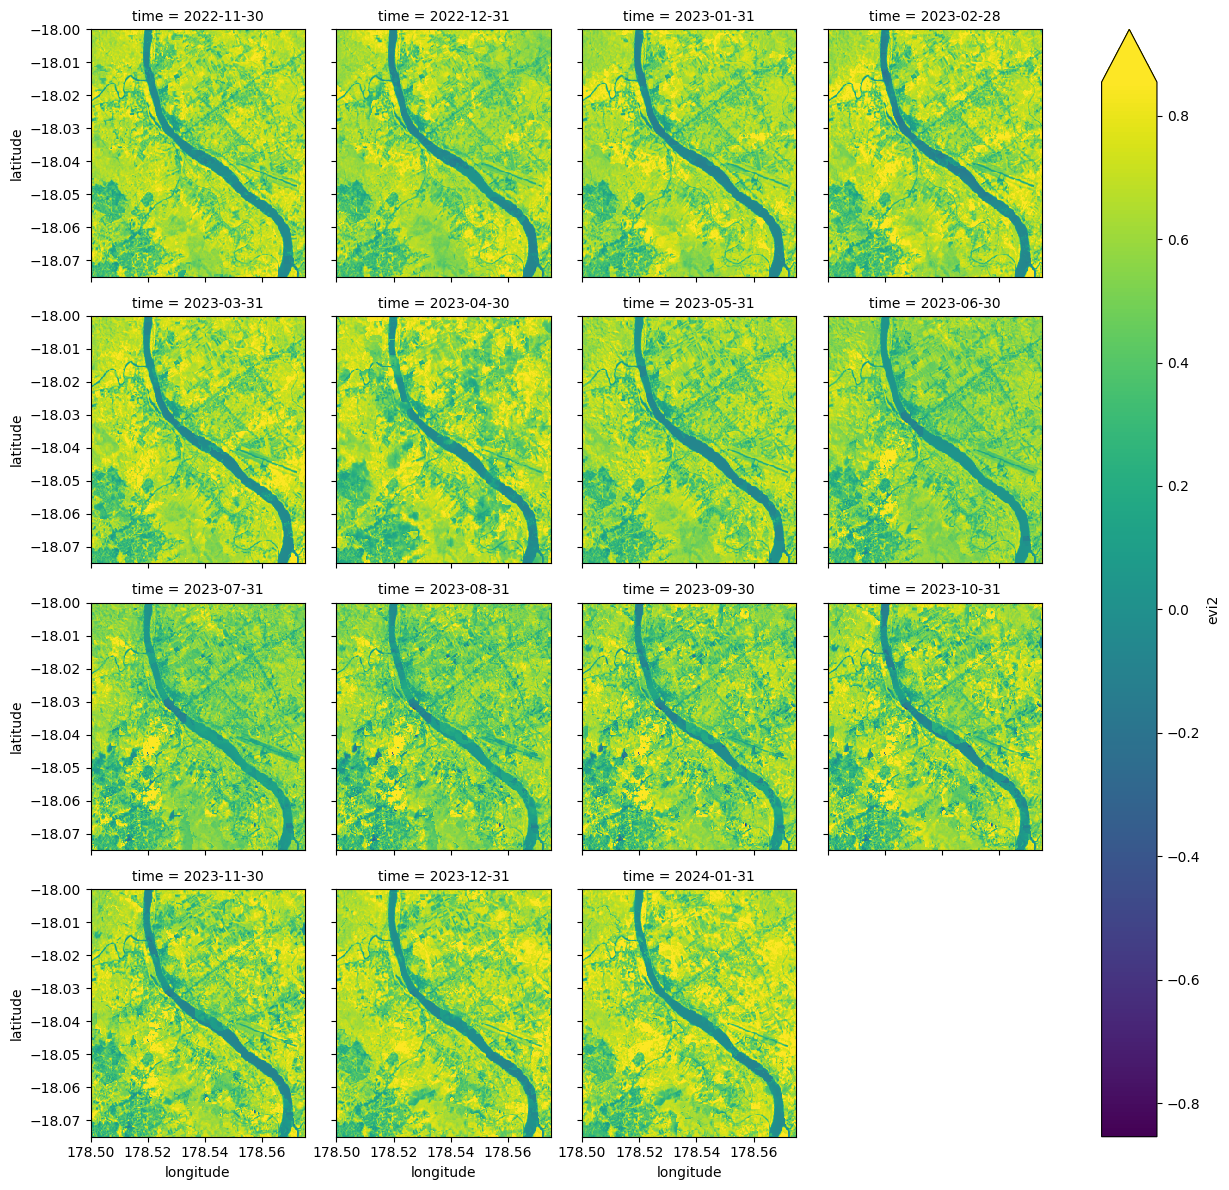

In [10]:
# Resample to monthly and interpolate missing values. This creates a more robust timeseries
monthly = loaded.evi2.resample(time="ME").max()
monthly = monthly.interpolate_na("time", method="polynomial", order=2).bfill("time").ffill("time")

monthly.plot.imshow(col="time", col_wrap=4, robust=True, cmap="viridis")

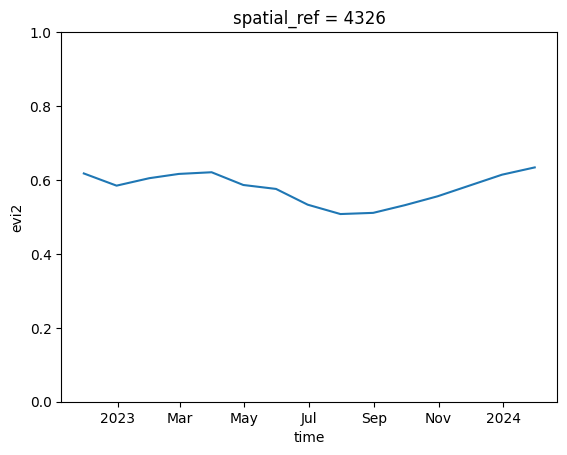

In [11]:
# Create a spatial median
summary = monthly.median(["longitude", "latitude"])

# Plot the time series
summary.plot(ylim=(0, 1))

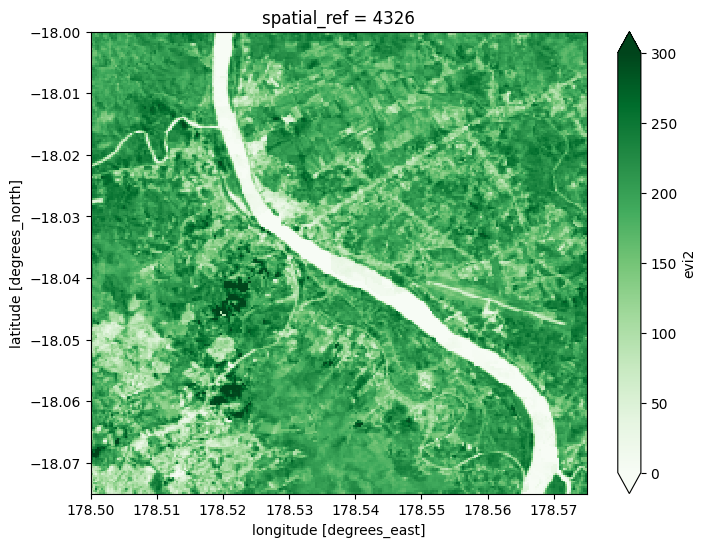

In [12]:
# Select just the year we are interested in and integrate over time
integral_monthly = monthly.sel(time="2023").integrate("time", datetime_unit="D")

# Plot the integral
integral_monthly.plot(robust=True, cmap="Greens", size=6, vmin=0, vmax=300)